# Data Pre-Processing:

In [1]:
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import seaborn as sns

2023-12-04 19:50:53.904834: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_ds = 'train/'
len(os.listdir(train_ds))

71056

### Base dataset

In [3]:
train = []
files = [file for file in os.listdir(train_ds) if '.jpg' in file or '.jpeg' in file]
for file in files[:25000]:
  try:
    img = Image.open(train_ds + f"{file}")
    if np.asarray(img).shape == (200, 200, 3):
      train.append(np.asarray(img))
  except Exception as e:
    print(e)

In [4]:
train = np.array(train)
train.shape

(24883, 200, 200, 3)

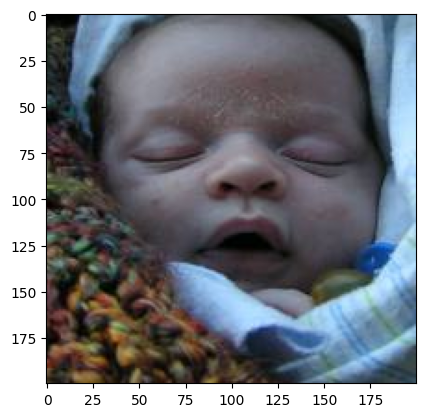

In [5]:
plt.imshow(train[0])

In [6]:
train = train.astype('float32') / 255.0

In [7]:
validation = train[int(len(train) * 0.8):]
train = train[:int(len(train) * 0.8)]
print(len(train))

19906


### Base Training

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (200, 200, 3)),
    keras.layers.Dense(2000, activation = 'selu'), 
    keras.layers.Dense(1000, activation = 'selu'), 
    keras.layers.Dense(500, activation = 'selu'), 
    keras.layers.Dense(200, activation = 'selu'),
    keras.layers.Dense(100, activation = 'selu'),

])
decoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [100]),
    keras.layers.Dense(200, activation = 'selu'),
    keras.layers.Dense(500, activation = 'selu'),
    keras.layers.Dense(1000, activation = 'selu'),
    keras.layers.Dense(2000, activation = 'selu'),
    keras.layers.Dense(200*200*3, activation = 'sigmoid'), 
    keras.layers.Reshape((200, 200, 3))
])

2023-12-04 19:51:13.671211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78823 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-12-04 19:51:13.675819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78823 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-12-04 19:51:13.677355: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78823 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2023-12-04 19:51:13.679068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78823 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                    metrics = rounded_accuracy)

In [11]:
autoencoder.fit(train, train, validation_data = [validation, validation],
                epochs = 10)

Epoch 1/10


2023-12-04 19:51:23.928770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-04 19:51:24.137218: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2b148b0ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-04 19:51:24.137267: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-04 19:51:24.137272: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-04 19:51:24.137277: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-04 19:51:24.137281: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-04 1

623/623 [==============================] - 19s 24ms/step - loss: 0.5742 - rounded_accuracy: 0.8198 - val_loss: 0.5610 - val_rounded_accuracy: 0.8462
Epoch 2/10
623/623 [==============================] - 13s 21ms/step - loss: 0.5531 - rounded_accuracy: 0.8577 - val_loss: 0.5559 - val_rounded_accuracy: 0.8551
Epoch 3/10
623/623 [==============================] - 13s 21ms/step - loss: 0.5479 - rounded_accuracy: 0.8674 - val_loss: 0.5482 - val_rounded_accuracy: 0.8685
Epoch 4/10
623/623 [==============================] - 13s 21ms/step - loss: 0.5450 - rounded_accuracy: 0.8725 - val_loss: 0.5471 - val_rounded_accuracy: 0.8689
Epoch 5/10
623/623 [==============================] - 13s 21ms/step - loss: 0.5434 - rounded_accuracy: 0.8754 - val_loss: 0.5450 - val_rounded_accuracy: 0.8738
Epoch 6/10
623/623 [==============================] - 13s 22ms/step - loss: 0.5419 - rounded_accuracy: 0.8781 - val_loss: 0.5438 - val_rounded_accuracy: 0.8756
Epoch 7/10
623/623 [==============================]

In [12]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=train, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 121ms/step


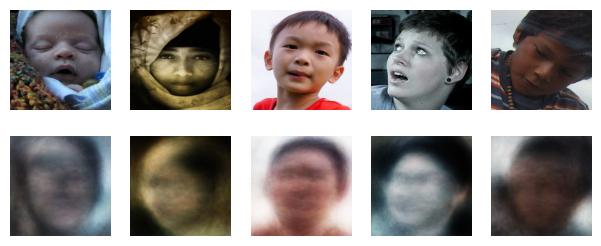

In [13]:
show_reconstructions(autoencoder)

In [14]:
embeddings = encoder.predict(train)

623/623 [==============================] - 2s 3ms/step


### Performing KMeans clustering, mapping each emotion to a cluster and visualizing using T-SNE

In [15]:
from sklearn.manifold import TSNE

X_valid_compressed = encoder.predict(train)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

623/623 [==============================] - 2s 3ms/step


In [16]:
emotions = {
    0:'neutral', 
    1:'happy', 
    2:'anger', 
    3:'fear', 
    4:'sad', 
    5:'surprise', 
    6:'disgust', 
    7:'contempt'
           }

emotion_labels = list(emotions.values())
emotion_clusters = emotions.keys()

kmeans = KMeans(n_clusters = len(emotion_labels)).fit(embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Using output below, change emotions dictionary to map each index to most appropriate cluster

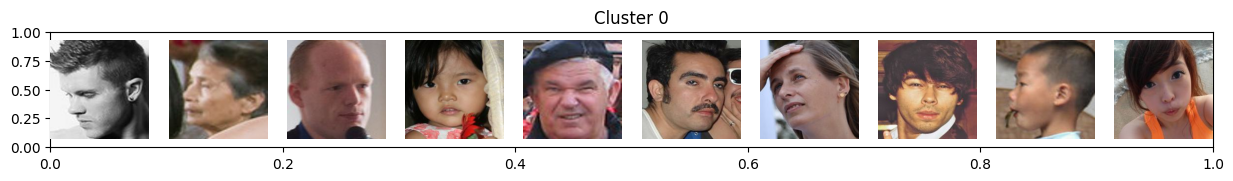

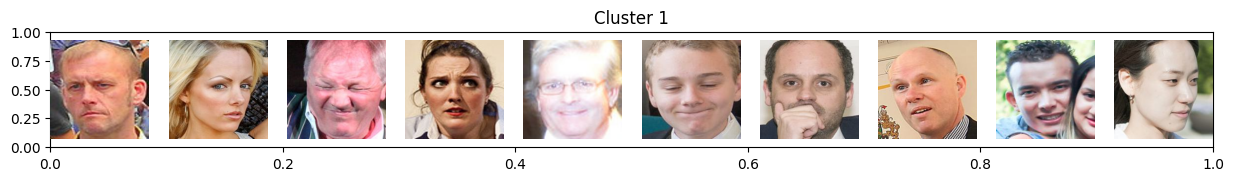

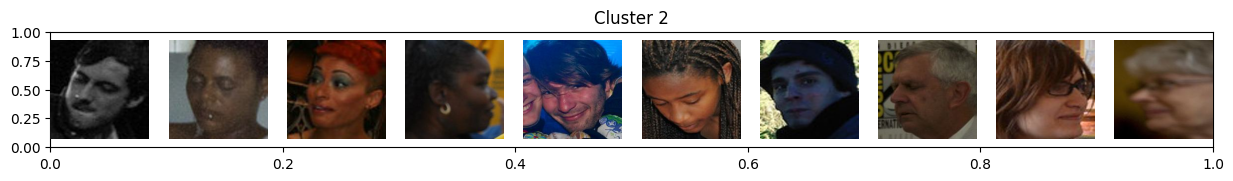

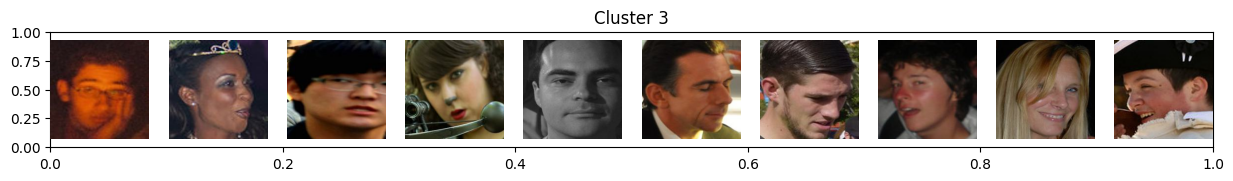

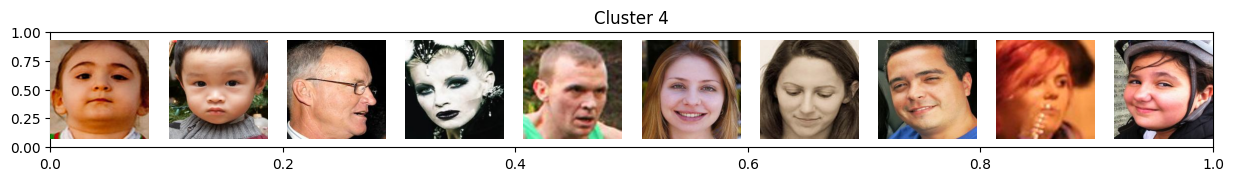

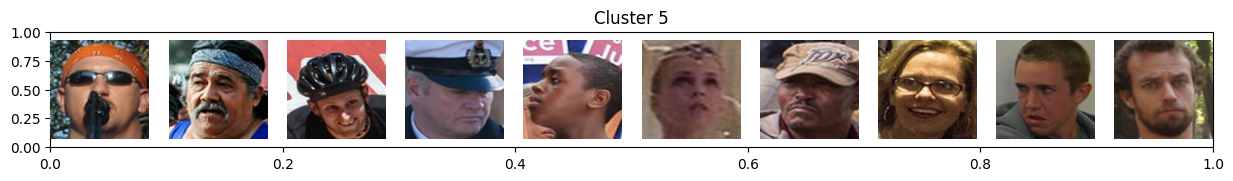

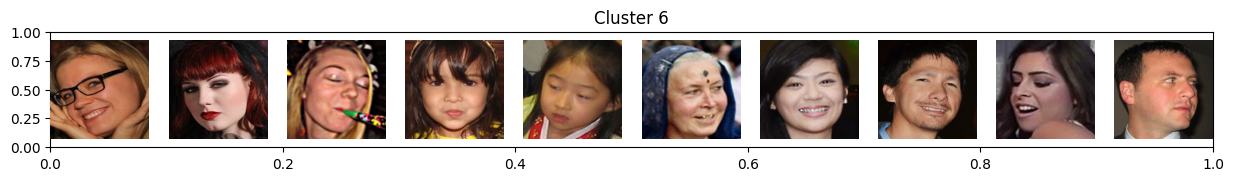

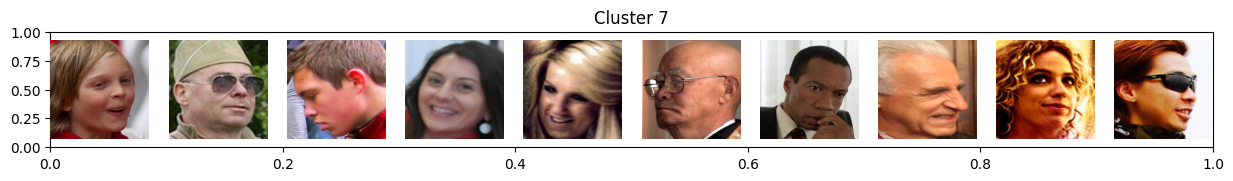

In [17]:
# Get cluster labels
cluster_labels = kmeans.labels_

# Number of clusters
num_clusters = kmeans.n_clusters

# Number of images to display per cluster
num_images_per_cluster = 10

# Iterate over each cluster
for cluster in range(num_clusters):
    # Find indices of data points in the current cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    
    # Select 10 random indices from the current cluster (or use a different strategy to select)
    selected_indices = np.random.choice(cluster_indices, size=min(num_images_per_cluster, len(cluster_indices)), replace=False)
    
    # Display images from the current cluster
    plt.figure(figsize=(15, 1.5))
    plt.title(f'Cluster {cluster}')
    for i, index in enumerate(selected_indices):
        plt.subplot(1, num_images_per_cluster, i + 1)
        plt.imshow(train[index].reshape((200, 200, 3)))  # Assuming images are 3D, adjust if needed
        plt.axis('off')
    plt.show()

Using the images from the clusters above, assign the best aligning emotion to each cluster in the dictionary below:

In [18]:
emotions = {
    0: 'contempt', 
    1: 'anger', 
    2: 'neutral', 
    3: 'sad', 
    4: 'fear', 
    5: 'disgust', 
    6: 'happy', 
    7: 'surprise'
           }

### Load and Evaluate Emotions using AffectNet Data

Predicting emotion:  neutral
161/161 [==============================] - 1s 3ms/step
1.0 %
Predicting emotion:  happy
158/158 [==============================] - 1s 3ms/step
19.0 %
Predicting emotion:  anger
101/101 [==============================] - 0s 3ms/step
19.0 %
Predicting emotion:  fear
100/100 [==============================] - 0s 3ms/step
19.0 %
Predicting emotion:  sad
97/97 [==============================] - 0s 3ms/step
7.000000000000001 %
Predicting emotion:  surprise
127/127 [==============================] - 0s 3ms/step
18.0 %
Predicting emotion:  disgust
78/78 [==============================] - 0s 3ms/step
7.000000000000001 %
Predicting emotion:  contempt
90/90 [==============================] - 0s 3ms/step
7.000000000000001 %
Overall test accuracy: 0.12264995523724262


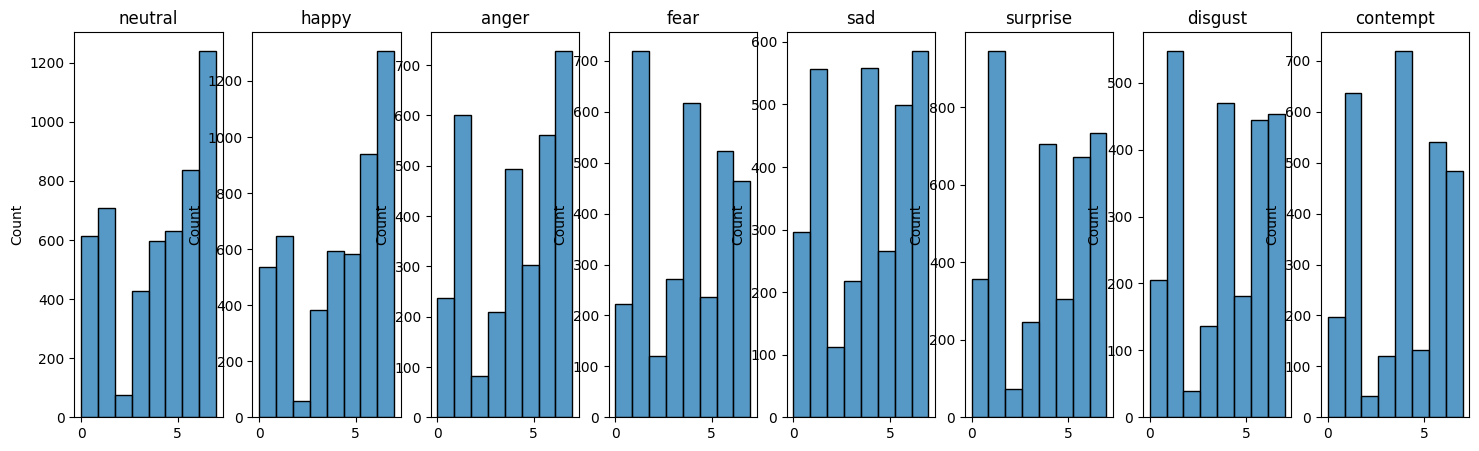

In [19]:
fig, axes = plt.subplots(1, len(emotion_labels), figsize=(18, 5))

h_index = 0

overall_correct = 0
overall_data_len = 0
for emotion in emotion_labels:
    print("Predicting emotion: ", emotion)
    test = []
    
    test_ds = 'affectnet/' + emotion + '/'
    test_files = [file for file in os.listdir(test_ds) if '.jpg' or '.png' in file]
    
    for file in test_files:
        try:
            #image = np.asarray((Image.open(test_ds + f"{file}")).convert('L').resize((200, 200)))
            image = np.asarray((Image.open(test_ds + f"{file}")).resize((200, 200)))
            test.append(image)
            overall_data_len += 1
        except Exception as e:
            print(e)
    
    test = np.array(test)
    test = test.astype('float32') / 255.0
    test_embeddings = encoder.predict(test)
    predictions = kmeans.predict(test_embeddings)
    
    sns.histplot(ax=axes[h_index], data=predictions, bins=len(emotion_labels)).set_title(emotion)
    
    correct = 0

    for key, value in emotions.items():
        if value == emotion:
            emotion_key = key
    
    for i in predictions:
      if i == emotion_key:
        correct += 1
        overall_correct += 1

    print(round(correct/len(predictions), 2)*100, '%')
    
    h_index += 1
    
print(f"Overall test accuracy: {overall_correct/overall_data_len}")

In [20]:
mapped_emotions = [emotion_labels[label] for label in kmeans.labels_]

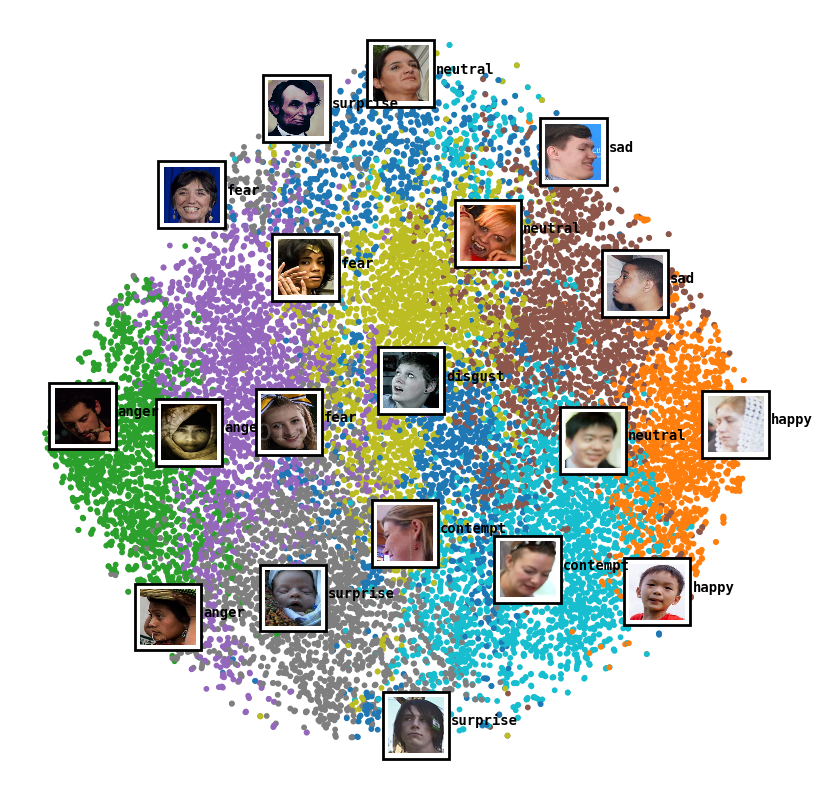

In [21]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)

plt.figure(figsize=(10, 10))
font_properties = {'family': 'monospace', 'color': 'black', 'weight': 'bold', 'size': 10}

cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c = kmeans.predict(embeddings), s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train[index], zoom=0.2, cmap="binary"),
            position, bboxprops={"lw": 2})
        plt.gca().add_artist(imagebox)
        plt.text(position[0] + 0.05, position[1], mapped_emotions[index], fontdict=font_properties)
plt.axis("off")
plt.show()

### Grayscale dataset

In [22]:
train = []
files = [file for file in os.listdir(train_ds) if '.jpg' in file or '.jpeg' in file]
for file in files[:25000]:
  try:
    img = Image.open(train_ds + f"{file}").convert('L')
    if np.asarray(img).shape == (200, 200):
      train.append(np.asarray(img))
  except Exception as e:
    print(e)

In [23]:
train = np.array(train)
train.shape

(25000, 200, 200)

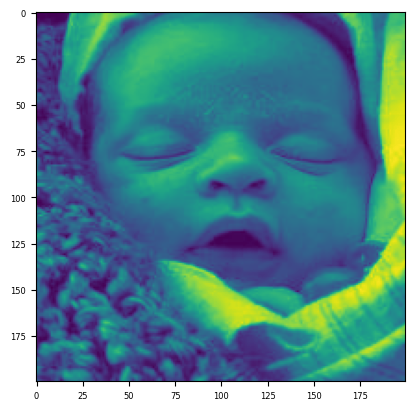

In [24]:
plt.imshow(train[0])

In [25]:
train = train.astype('float32') / 255.0

In [26]:
validation = train[int(len(train) * 0.8):]
train = train[:int(len(train) * 0.8)]

print(len(train))

20000


### Grayscale training

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (200, 200, 1)),
    keras.layers.Dense(2000, activation = 'selu'), 
    keras.layers.Dense(1000, activation = 'selu'), 
    keras.layers.Dense(500, activation = 'selu'), 
    keras.layers.Dense(200, activation = 'selu'),
    keras.layers.Dense(100, activation = 'selu'),

])
decoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [100]),
    keras.layers.Dense(200, activation = 'selu'),
    keras.layers.Dense(500, activation = 'selu'),
    keras.layers.Dense(1000, activation = 'selu'),
    keras.layers.Dense(2000, activation = 'selu'),
    keras.layers.Dense(200*200*1, activation = 'sigmoid'), 
    keras.layers.Reshape((200, 200, 1))
])

In [28]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                    metrics = rounded_accuracy)

In [29]:
autoencoder.fit(train, train, validation_data = [validation, validation],
                epochs = 10)

Epoch 1/10
625/625 [==============================] - 9s 10ms/step - loss: 0.5850 - rounded_accuracy: 0.8197 - val_loss: 0.5700 - val_rounded_accuracy: 0.8528
Epoch 2/10
625/625 [==============================] - 5s 9ms/step - loss: 0.5656 - rounded_accuracy: 0.8608 - val_loss: 0.5637 - val_rounded_accuracy: 0.8645
Epoch 3/10
625/625 [==============================] - 5s 9ms/step - loss: 0.5615 - rounded_accuracy: 0.8698 - val_loss: 0.5601 - val_rounded_accuracy: 0.8747
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.5589 - rounded_accuracy: 0.8754 - val_loss: 0.5588 - val_rounded_accuracy: 0.8758
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5571 - rounded_accuracy: 0.8796 - val_loss: 0.5576 - val_rounded_accuracy: 0.8789
Epoch 6/10
625/625 [==============================] - 5s 9ms/step - loss: 0.5559 - rounded_accuracy: 0.8824 - val_loss: 0.5563 - val_rounded_accuracy: 0.8835
Epoch 7/10
625/625 [==============================]

In [30]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=train, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 98ms/step


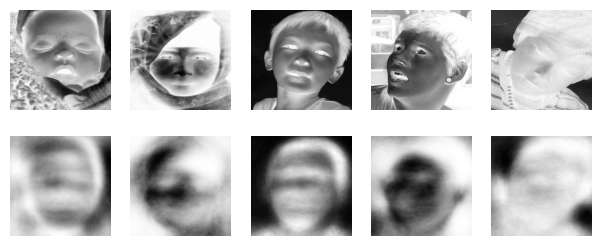

In [31]:
show_reconstructions(autoencoder)

In [32]:
embeddings = encoder.predict(train)

625/625 [==============================] - 1s 1ms/step


### Performing KMeans clustering, mapping each emotion to a cluster and visualizing using T-SNE (Grayscale)

In [33]:
from sklearn.manifold import TSNE

X_valid_compressed = encoder.predict(train)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

625/625 [==============================] - 1s 1ms/step


In [34]:
emotions = {
    0:'neutral', 
    1:'happy', 
    2:'anger', 
    3:'fear', 
    4:'sad', 
    5:'surprise', 
    6:'disgust', 
    7:'contempt'
           }

emotion_labels = list(emotions.values())
emotion_clusters = emotions.keys()

kmeans = KMeans(n_clusters = len(emotion_labels)).fit(embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


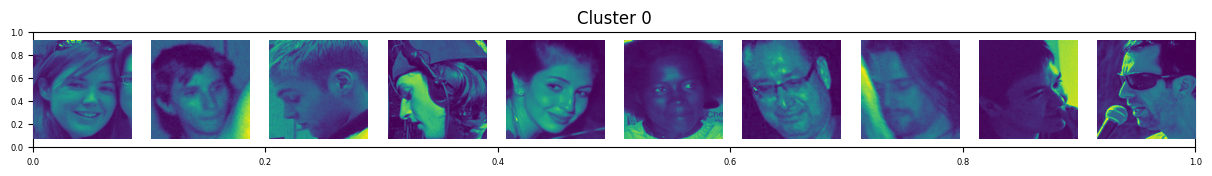

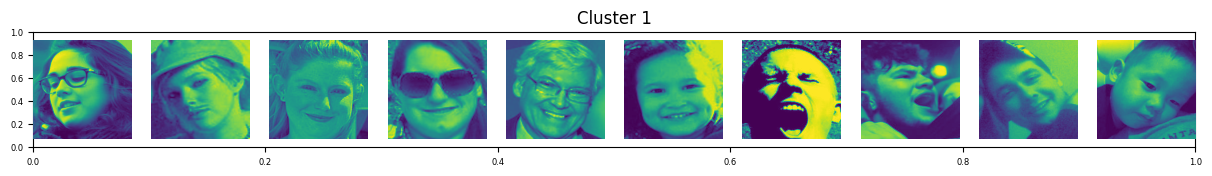

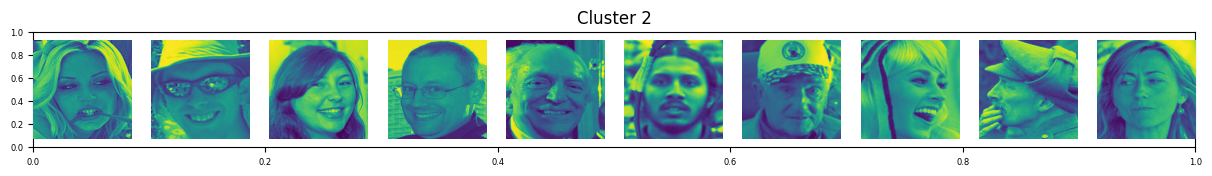

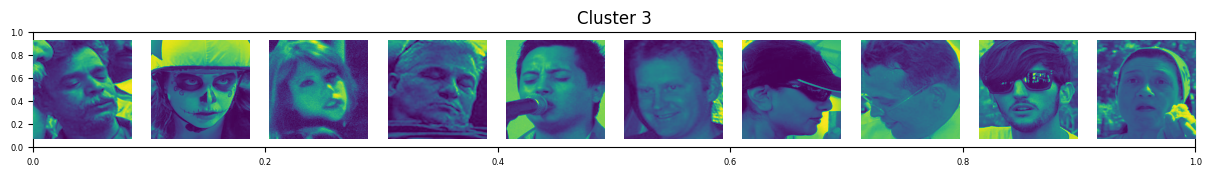

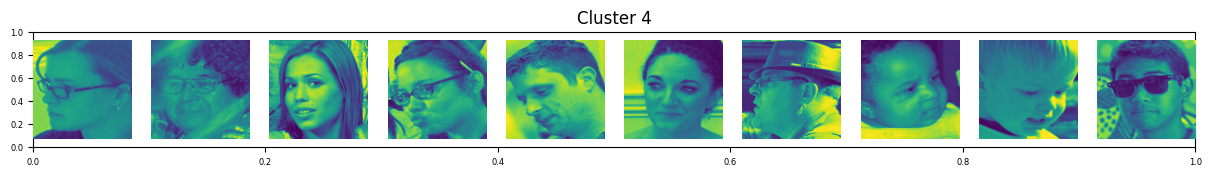

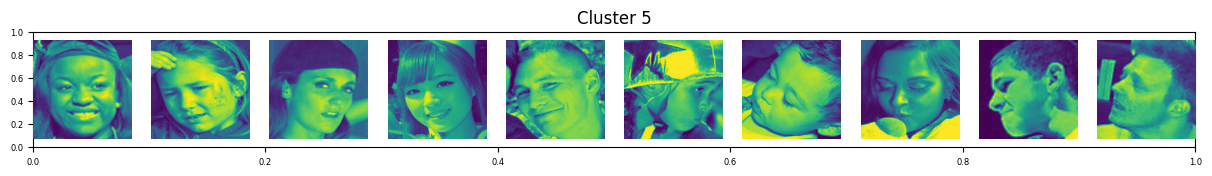

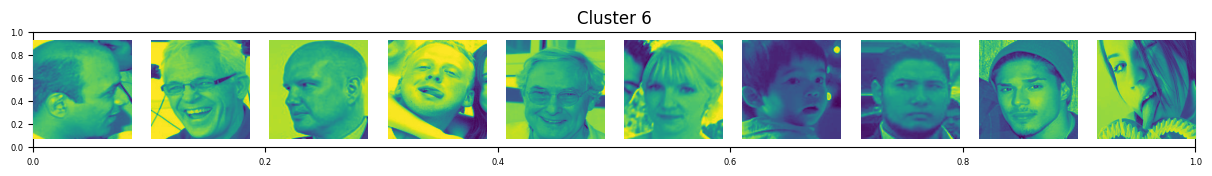

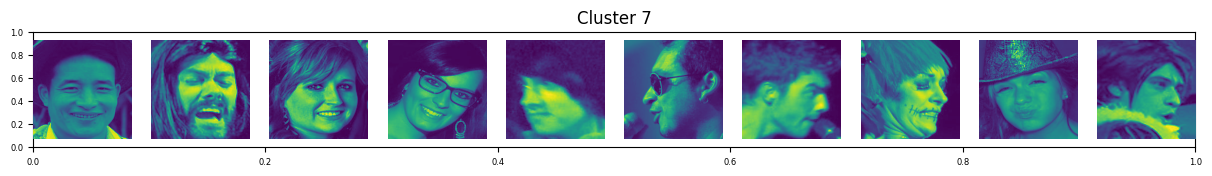

In [35]:
# Get cluster labels
cluster_labels = kmeans.labels_

# Number of clusters
num_clusters = kmeans.n_clusters

# Number of images to display per cluster
num_images_per_cluster = 10

# Iterate over each cluster
for cluster in range(num_clusters):
    # Find indices of data points in the current cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    
    # Select 10 random indices from the current cluster (or use a different strategy to select)
    selected_indices = np.random.choice(cluster_indices, size=min(num_images_per_cluster, len(cluster_indices)), replace=False)
    
    # Display images from the current cluster
    plt.figure(figsize=(15, 1.5))
    plt.title(f'Cluster {cluster}')
    for i, index in enumerate(selected_indices):
        plt.subplot(1, num_images_per_cluster, i + 1)
        plt.imshow(train[index].reshape((200, 200)))  # Assuming images are 3D, adjust if needed
        plt.axis('off')
    plt.show()

Using the images from the clusters above, assign the best aligning emotion to each cluster in the dictionary below:

In [36]:
emotions = {
    0: 'neutral', 
    1: 'anger', 
    2: 'happy', 
    3: 'fear', 
    4: 'contempt', 
    5: 'sad', 
    6: 'disgust', 
    7: 'surprise'
           }

### Load and Evaluate Emotions using AffectNet Data (Grayscale)

Predicting emotion:  neutral
161/161 [==============================] - 0s 1ms/step
2.0 %
Predicting emotion:  happy
158/158 [==============================] - 0s 1ms/step
18.0 %
Predicting emotion:  anger
101/101 [==============================] - 0s 2ms/step
23.0 %
Predicting emotion:  fear
100/100 [==============================] - 0s 2ms/step
7.000000000000001 %
Predicting emotion:  sad
97/97 [==============================] - 0s 1ms/step
12.0 %
Predicting emotion:  surprise
127/127 [==============================] - 0s 1ms/step
10.0 %
Predicting emotion:  disgust
78/78 [==============================] - 0s 1ms/step
24.0 %
Predicting emotion:  contempt
90/90 [==============================] - 0s 1ms/step
10.0 %
Overall test accuracy: 0.1252668548998003


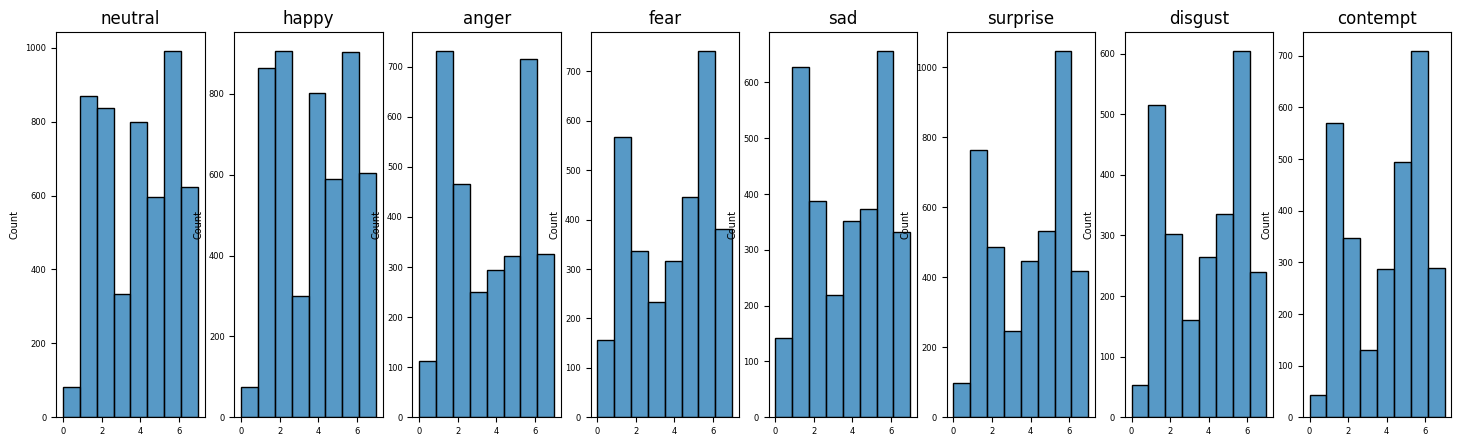

In [37]:
fig, axes = plt.subplots(1, len(emotion_labels), figsize=(18, 5))

h_index = 0

overall_correct = 0
overall_data_len = 0
for emotion in emotion_labels:
    print("Predicting emotion: ", emotion)
    test = []
    
    test_ds = 'affectnet/' + emotion + '/'
    test_files = [file for file in os.listdir(test_ds) if '.jpg' or '.png' in file]
    
    for file in test_files:
        try:
            image = np.asarray((Image.open(test_ds + f"{file}")).convert('L').resize((200, 200)))
#             image = np.asarray((Image.open(test_ds + f"{file}")).resize((200, 200)))
            test.append(image)
            overall_data_len += 1
        except Exception as e:
            print(e)
    
    test = np.array(test)
    test = test.astype('float32') / 255.0
    test_embeddings = encoder.predict(test)
    predictions = kmeans.predict(test_embeddings)
    
    sns.histplot(ax=axes[h_index], data=predictions, bins=len(emotion_labels)).set_title(emotion)
    
    correct = 0

    for key, value in emotions.items():
        if value == emotion:
            emotion_key = key
    
    for i in predictions:
      if i == emotion_key:
        correct += 1
        overall_correct += 1

    print(round(correct/len(predictions), 2)*100, '%')
    
    h_index += 1
    
print(f"Overall test accuracy: {overall_correct/overall_data_len}")

In [38]:
mapped_emotions = [emotion_labels[label] for label in kmeans.labels_]

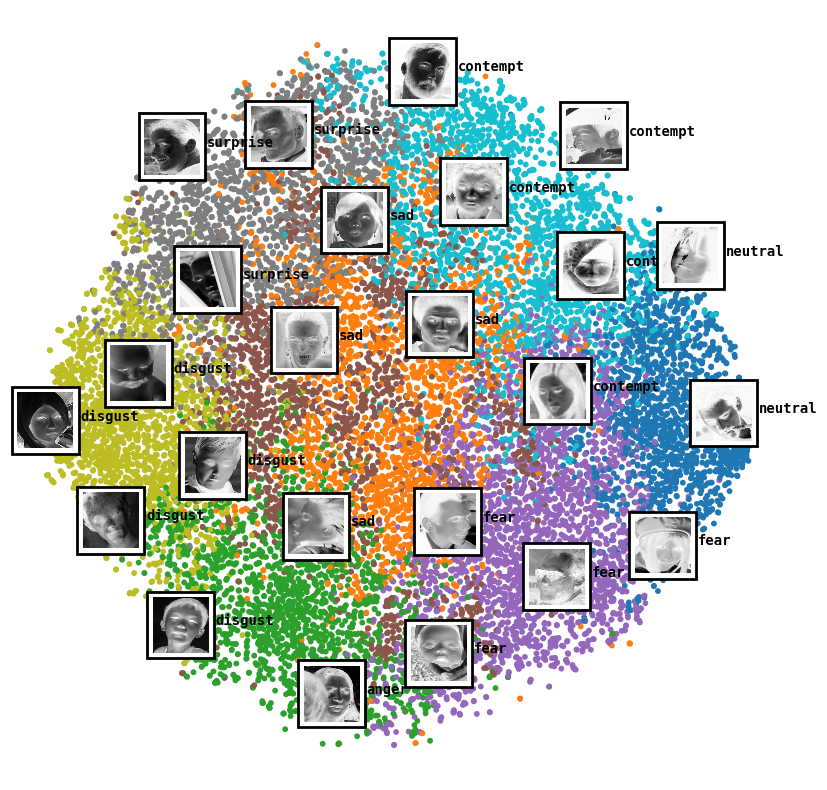

In [39]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)

plt.figure(figsize=(10, 10))
font_properties = {'family': 'monospace', 'color': 'black', 'weight': 'bold', 'size': 10}

cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c = kmeans.predict(embeddings), s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train[index], zoom=0.2, cmap="binary"),
            position, bboxprops={"lw": 2})
        plt.gca().add_artist(imagebox)
        plt.text(position[0] + 0.05, position[1], mapped_emotions[index], fontdict=font_properties)
plt.axis("off")
plt.show()

### Cropped dataset

In [62]:
train = []
files = [file for file in os.listdir(train_ds) if '.jpg' in file or '.jpeg' in file]
for file in files[:25000]:
  try:
    img = Image.open(train_ds + f"{file}").crop((25, 25, 175, 175))
    if np.asarray(img).shape == (150, 150, 3):
      train.append(np.asarray(img))
  except Exception as e:
    print(e)

In [63]:
train = np.array(train)
train.shape

(24883, 150, 150, 3)

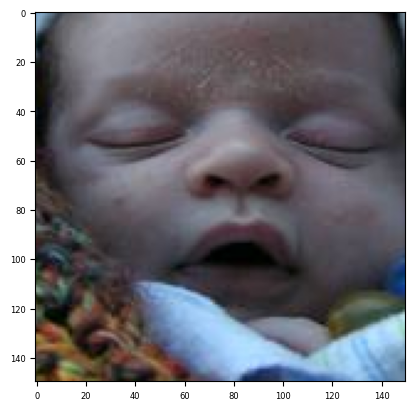

In [64]:
plt.imshow(train[0])

In [65]:
train = train.astype('float32') / 255.0

In [66]:
validation = train[int(len(train) * 0.8):]
train = train[:int(len(train) * 0.8)]

print(len(train))

19906


### Cropped training

In [67]:
tf.random.set_seed(42)
np.random.seed(42)

encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (150, 150, 3)),
    keras.layers.Dense(2000, activation = 'selu'), 
    keras.layers.Dense(1000, activation = 'selu'), 
    keras.layers.Dense(500, activation = 'selu'), 
    keras.layers.Dense(200, activation = 'selu'),
    keras.layers.Dense(100, activation = 'selu'),

])
decoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [100]),
    keras.layers.Dense(200, activation = 'selu'),
    keras.layers.Dense(500, activation = 'selu'),
    keras.layers.Dense(1000, activation = 'selu'),
    keras.layers.Dense(2000, activation = 'selu'),
    keras.layers.Dense(150*150*3, activation = 'sigmoid'), 
    keras.layers.Reshape((150, 150, 3))
])

In [68]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                    metrics = rounded_accuracy)

In [69]:
autoencoder.fit(train, train, validation_data = [validation, validation],
                epochs = 10)

Epoch 1/10
623/623 [==============================] - 12s 16ms/step - loss: 0.5846 - rounded_accuracy: 0.8320 - val_loss: 0.5728 - val_rounded_accuracy: 0.8562
Epoch 2/10
623/623 [==============================] - 8s 13ms/step - loss: 0.5667 - rounded_accuracy: 0.8694 - val_loss: 0.5661 - val_rounded_accuracy: 0.8716
Epoch 3/10
623/623 [==============================] - 8s 14ms/step - loss: 0.5617 - rounded_accuracy: 0.8806 - val_loss: 0.5617 - val_rounded_accuracy: 0.8827
Epoch 4/10
623/623 [==============================] - 9s 14ms/step - loss: 0.5594 - rounded_accuracy: 0.8857 - val_loss: 0.5603 - val_rounded_accuracy: 0.8859
Epoch 5/10
623/623 [==============================] - 9s 14ms/step - loss: 0.5576 - rounded_accuracy: 0.8900 - val_loss: 0.5602 - val_rounded_accuracy: 0.8844
Epoch 6/10
623/623 [==============================] - 9s 14ms/step - loss: 0.5563 - rounded_accuracy: 0.8929 - val_loss: 0.5595 - val_rounded_accuracy: 0.8876
Epoch 7/10
623/623 [=========================

In [70]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=train, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 97ms/step


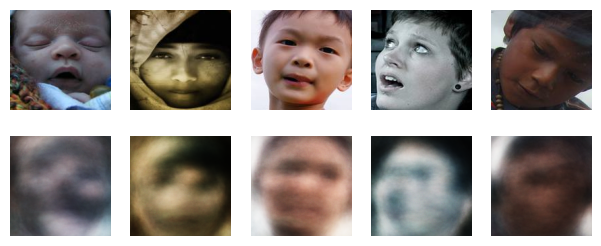

In [71]:
show_reconstructions(autoencoder)

In [72]:
embeddings = encoder.predict(train)

623/623 [==============================] - 2s 2ms/step


### Performing KMeans clustering, mapping each emotion to a cluster and visualizing using T-SNE (Cropped)

In [73]:
from sklearn.manifold import TSNE

X_valid_compressed = encoder.predict(train)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

623/623 [==============================] - 1s 2ms/step


In [74]:
emotions = {
    0:'neutral', 
    1:'happy', 
    2:'anger', 
    3:'fear', 
    4:'sad', 
    5:'surprise', 
    6:'disgust', 
    7:'contempt'
           }

emotion_labels = list(emotions.values())
emotion_clusters = emotions.keys()

kmeans = KMeans(n_clusters = len(emotion_labels)).fit(embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


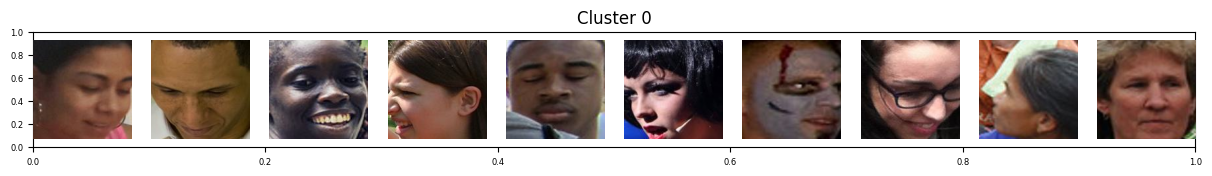

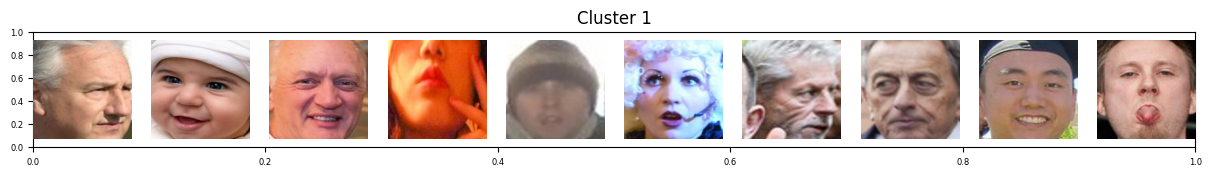

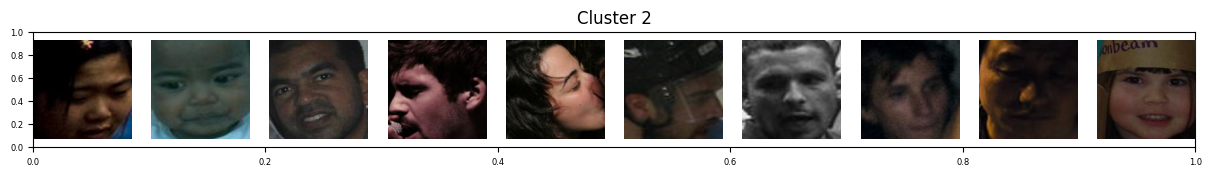

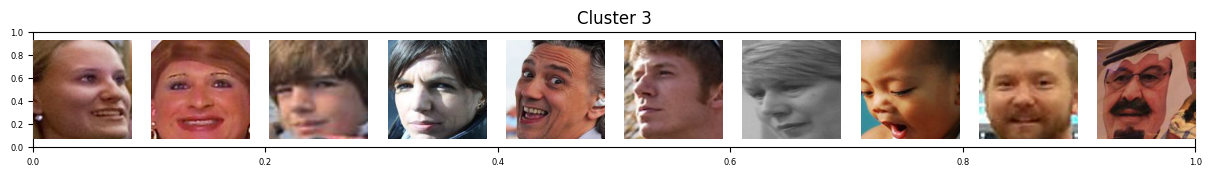

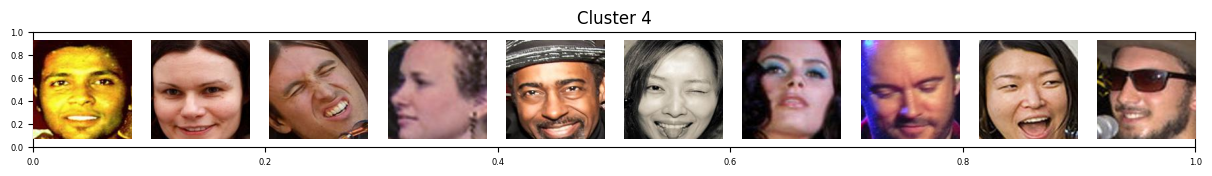

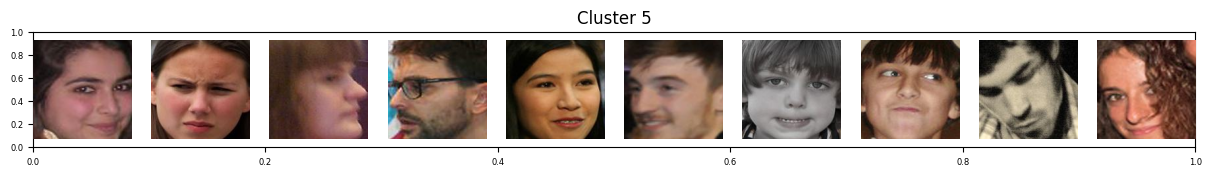

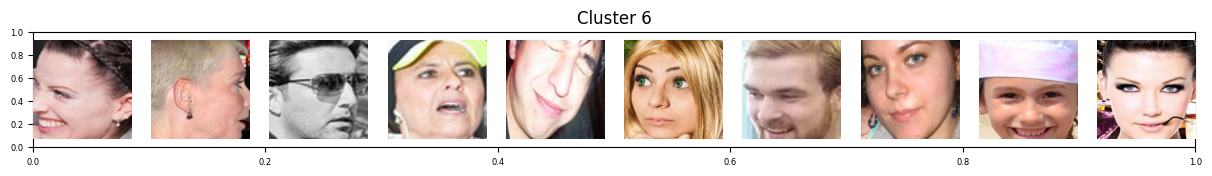

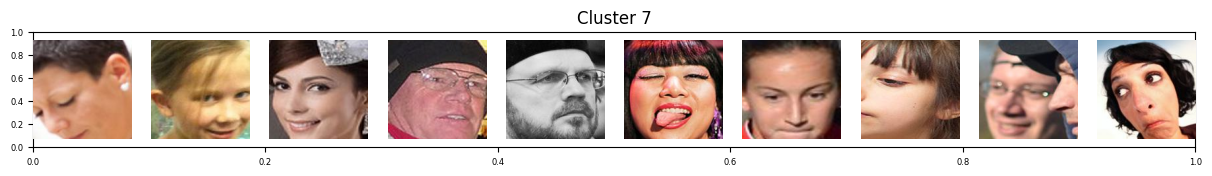

In [75]:
# Get cluster labels
cluster_labels = kmeans.labels_

# Number of clusters
num_clusters = kmeans.n_clusters

# Number of images to display per cluster
num_images_per_cluster = 10

# Iterate over each cluster
for cluster in range(num_clusters):
    # Find indices of data points in the current cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    
    # Select 10 random indices from the current cluster (or use a different strategy to select)
    selected_indices = np.random.choice(cluster_indices, size=min(num_images_per_cluster, len(cluster_indices)), replace=False)
    
    # Display images from the current cluster
    plt.figure(figsize=(15, 1.5))
    plt.title(f'Cluster {cluster}')
    for i, index in enumerate(selected_indices):
        plt.subplot(1, num_images_per_cluster, i + 1)
        plt.imshow(train[index].reshape((150, 150, 3)))  # Assuming images are 3D, adjust if needed
        plt.axis('off')
    plt.show()

Using the images from the clusters above, assign the best aligning emotion to each cluster in the dictionary below:

In [77]:
emotions = {
    0: 'neutral', 
    1: 'anger', 
    2: 'fear', 
    3: 'sad', 
    4: 'happy', 
    5: 'contempt', 
    6: 'disgust', 
    7: 'surprise'
           }

### Load and Evaluate Emotions using AffectNet Data (Cropped)

Predicting emotion:  neutral
161/161 [==============================] - 1s 2ms/step
15.0 %
Predicting emotion:  happy
158/158 [==============================] - 1s 2ms/step
6.0 %
Predicting emotion:  anger
101/101 [==============================] - 1s 2ms/step
19.0 %
Predicting emotion:  fear
100/100 [==============================] - 0s 2ms/step
4.0 %
Predicting emotion:  sad
97/97 [==============================] - 0s 2ms/step
21.0 %
Predicting emotion:  surprise
127/127 [==============================] - 1s 2ms/step
9.0 %
Predicting emotion:  disgust
78/78 [==============================] - 1s 2ms/step
12.0 %
Predicting emotion:  contempt
90/90 [==============================] - 1s 2ms/step
10.0 %
Overall test accuracy: 0.11838027684043799


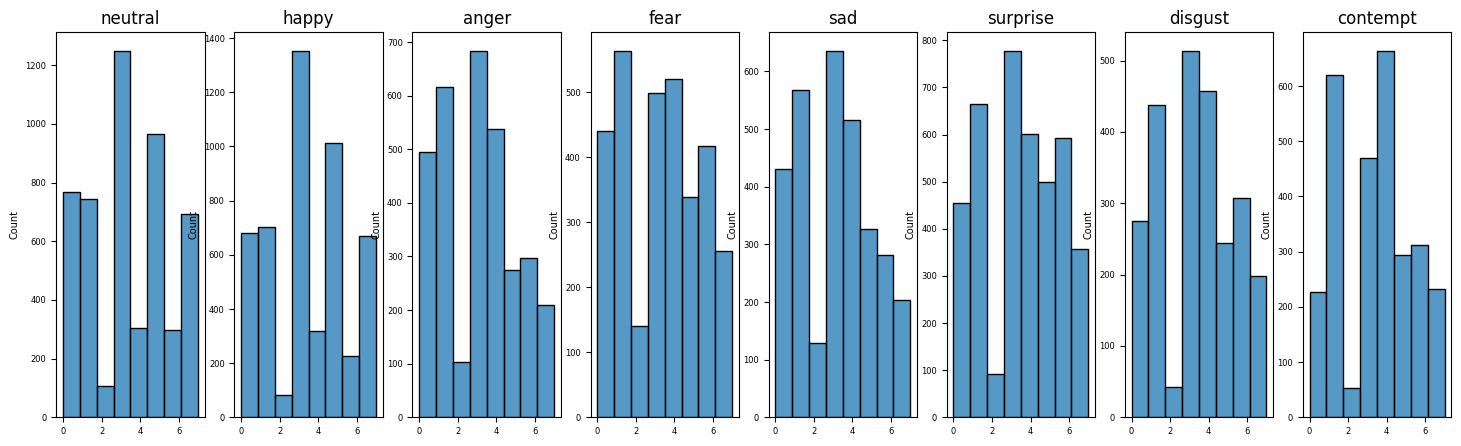

In [78]:
fig, axes = plt.subplots(1, len(emotion_labels), figsize=(18, 5))

h_index = 0

overall_correct = 0
overall_data_len = 0
for emotion in emotion_labels:
    print("Predicting emotion: ", emotion)
    test = []
    
    test_ds = 'affectnet/' + emotion + '/'
    test_files = [file for file in os.listdir(test_ds) if '.jpg' or '.png' in file]
    
    for file in test_files:
        try:
#             image = np.asarray((Image.open(test_ds + f"{file}")).convert('L').resize((200, 200)))
            image = np.asarray((Image.open(test_ds + f"{file}")).resize((150, 150)))
            test.append(image)
            overall_data_len += 1
        except Exception as e:
            print(e)
    
    test = np.array(test)
    test = test.astype('float32') / 255.0
    test_embeddings = encoder.predict(test)
    predictions = kmeans.predict(test_embeddings)
    
    sns.histplot(ax=axes[h_index], data=predictions, bins=len(emotion_labels)).set_title(emotion)
    
    correct = 0

    for key, value in emotions.items():
        if value == emotion:
            emotion_key = key
    
    for i in predictions:
      if i == emotion_key:
        correct += 1
        overall_correct += 1

    print(round(correct/len(predictions), 2)*100, '%')
    
    h_index += 1
    
print(f"Overall test accuracy: {overall_correct/overall_data_len}")

In [79]:
mapped_emotions = [emotion_labels[label] for label in kmeans.labels_]

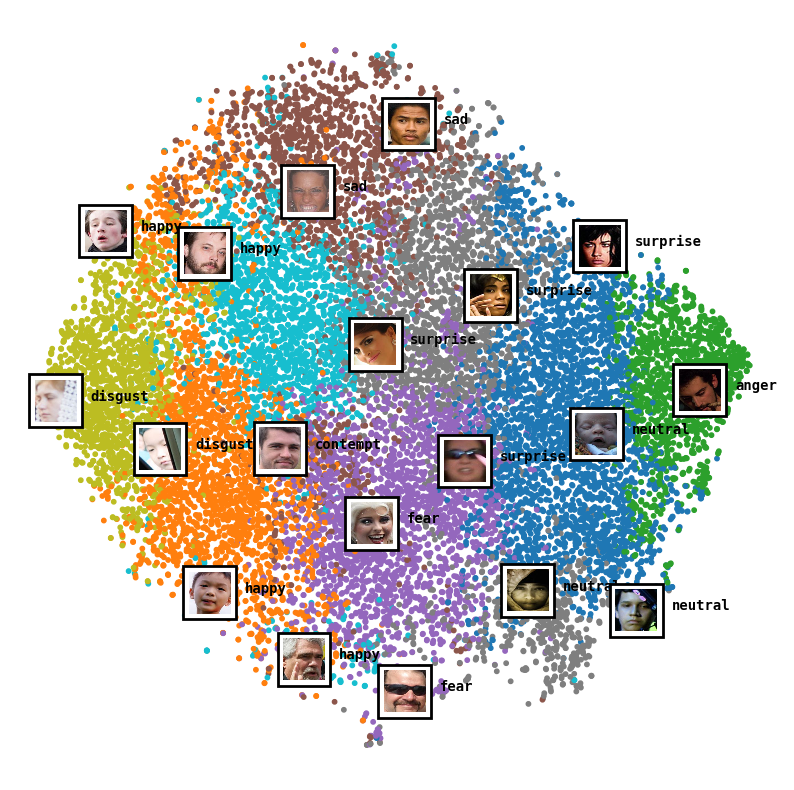

In [80]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)

plt.figure(figsize=(10, 10))
font_properties = {'family': 'monospace', 'color': 'black', 'weight': 'bold', 'size': 10}

cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c = kmeans.predict(embeddings), s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train[index], zoom=0.2, cmap="binary"),
            position, bboxprops={"lw": 2})
        plt.gca().add_artist(imagebox)
        plt.text(position[0] + 0.05, position[1], mapped_emotions[index], fontdict=font_properties)
plt.axis("off")
plt.show()